# The new idea

We will have a thing that selects the seeds first according to their values here

prime number rule
multiples of 2, will be shade loving, those not are not
multiples of 3, will be border suitable, those not are not

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode

In [2]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), seed: int = None):
            """
            Args:
                octave (float): octave value from range [1-2] for Perlin noise.
                grid_size (tuple): (width, height) of the grid, defaults to (100, 100).
                seed (int): Random seed for reproducibility, defaults to None.
            """
            super(customSpatialEnv, self).__init__()
            self.seed_value = seed
            self.random_state = np.random.RandomState(seed)  # Controlled randomness
            self.grid_size = grid_size
            self.octave = octave
            self.max_attempts = 100000  # Maximum number of attempts
            self.attempt_counter = 0  # Tracks the number of attempts

            self.grid, self.planting_coordinates, self.distances = self._create_environment()

            # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
            self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

            # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
            self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

            # Observation space: Dict containing the grid and distances (both horizontal and vertical)
            self.observation_space = spaces.Dict({
                "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
                "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
                "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
                "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
                "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
                "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
            })

            self.num_trees = 0
            self.num_shrubs = 0
            self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment using Perlin noise.
        """
        while True:
            # Use the random state for reproducibility
            seed = self.random_state.randint(0, 50) if self.seed_value is None else self.seed_value
            noise = PerlinNoise(octaves=self.octave, seed=seed)
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5 / 100:
                break

        planting_grid, planting_coords = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)  # Adjust input as needed
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path, seed=None):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.

    Args:
        model_path (str): Path to the pretrained model.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        np.ndarray: Final grid with plant placements.
    """
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100), seed=seed)
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()

Visualisers

In [3]:
def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()



In [4]:
def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

In [37]:
def visualize_binary_grid(grid, title="Binary Grid"):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


Loaded model from ./models/23rd.zip
Episode finished after 1130 steps


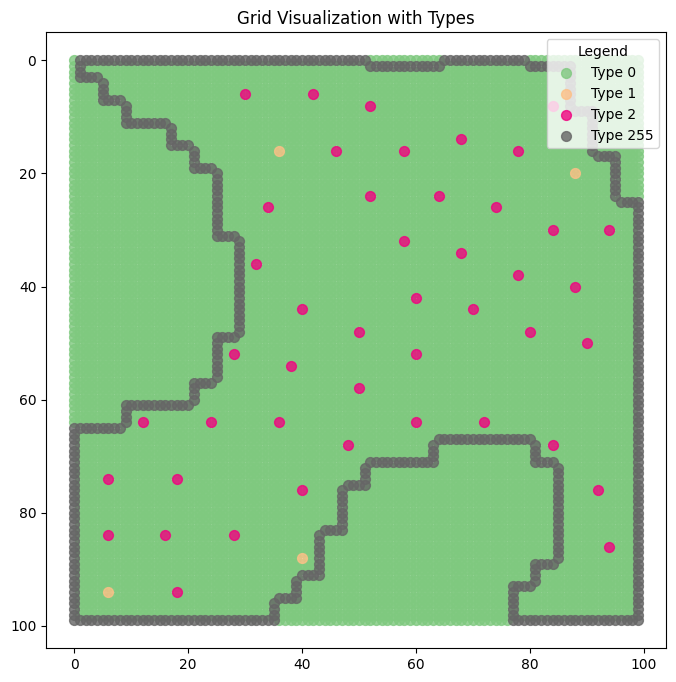

In [10]:
model = "./models/23rd.zip" # Model used for the grid Generation
grid = createGrid(model_path=model, seed=0)

visualize_grid_with_types(grid)
# 1s are trees, 2s are shrubs

In [11]:
def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()
    
    return shaded_grid


In [21]:
def calculate_distance_to_border(grid, cutoff=1, max_cutoff=0.7):
    """
    Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
    Includes a cutoff value to ignore distances below the cutoff threshold and a max_cutoff to cap the distance.
    Allows max_cutoff to be specified as a percentage of the maximum distance.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value before starting to increase. Default is 1.
        max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.

    Returns:
        np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Apply cutoff
    distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)

    # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
    max_distance = np.max(distance_to_border)
    if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
        max_cutoff = max_cutoff * max_distance

    # Apply max_cutoff if specified
    if max_cutoff is not None:
        distance_to_border = np.where(distance_to_border <= max_cutoff, distance_to_border, max_cutoff)

    # Normalize the distances to ensure the innermost area is 100
    if max_distance > 0:
        normalized_distance_map = (distance_to_border / max_distance) * 100  # Scale to range [0, 100]
    else:
        normalized_distance_map = distance_to_border  # If no distance, return the original map

    # Flip the distance map vertically
    flipped_distance_map = np.flipud(normalized_distance_map)

    return flipped_distance_map

In [35]:
def calculate_border_proximity(grid, cutoff=1, max_cutoff=1, constant_zone=0.3):
    """
    Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
    Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
    a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
        max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
        constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                             If between 0 and 1, treated as a percentage.

    Returns:
        np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Calculate max_distance for normalization and percentage-based calculations
    max_distance = np.max(distance_to_border)

    # Convert constant_zone to an absolute value if it's a percentage (0 < constant_zone <= 1)
    if 0 < constant_zone <= 1:
        constant_zone = constant_zone * max_distance

    # Maintain a constant value of 100 in the constant zone
    proximity_map = np.zeros_like(distance_to_border)
    proximity_map[distance_to_border <= constant_zone] = 100

    # Normalize the distances beyond the constant zone
    beyond_constant_zone = distance_to_border > constant_zone
    if max_distance > 0:
        normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
        proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

    # Apply cutoff to remove low-proximity regions
    proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

    # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
    if 0 < max_cutoff <= 1:
        max_cutoff = max_cutoff * max_distance

    # Apply max_cutoff to limit the proximity range
    if max_cutoff is not None:
        proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

    # Flip the proximity map vertically
    flipped_proximity_map = np.flipud(proximity_map)

    return flipped_proximity_map


Loaded model from ./models/23rd.zip
Episode finished after 806 steps


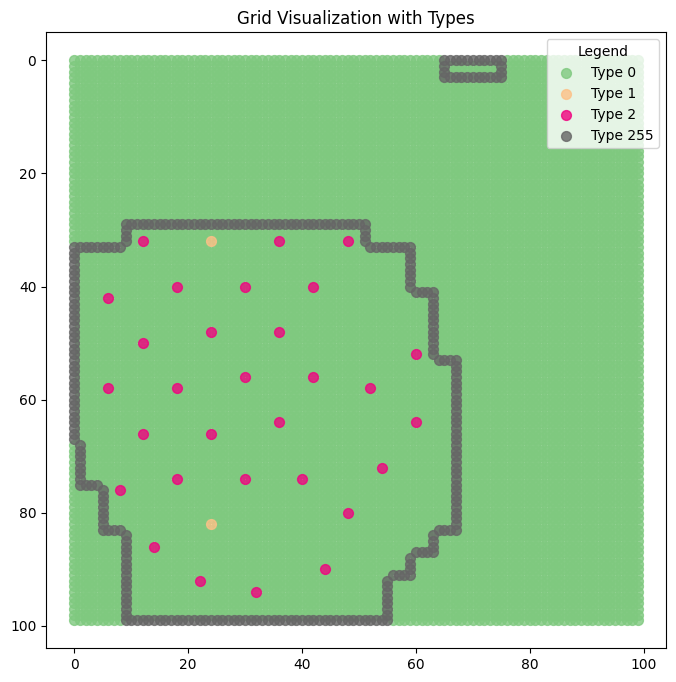

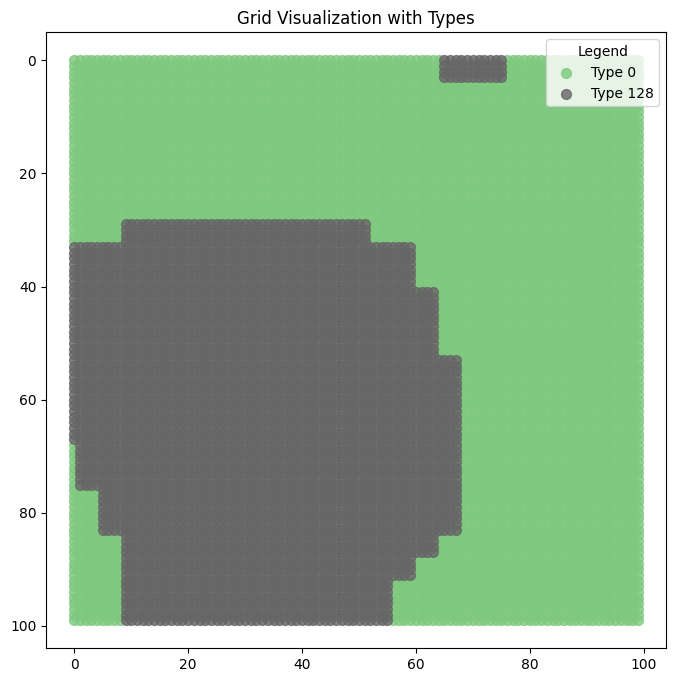

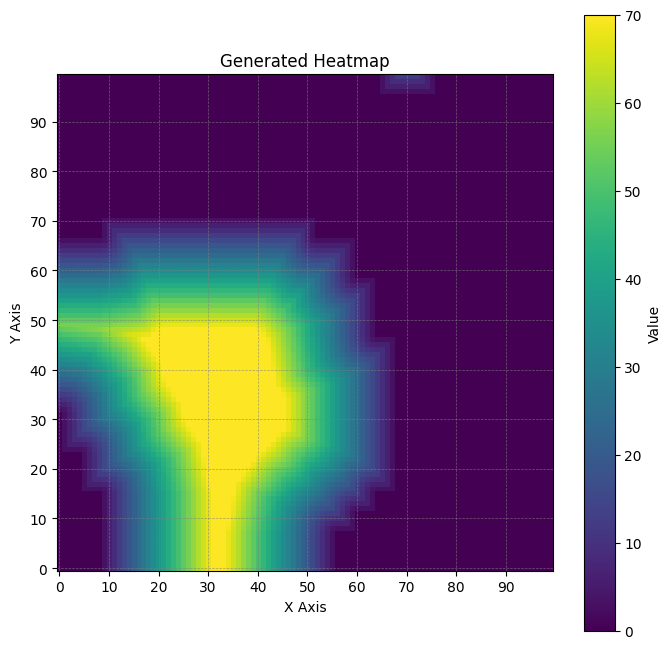

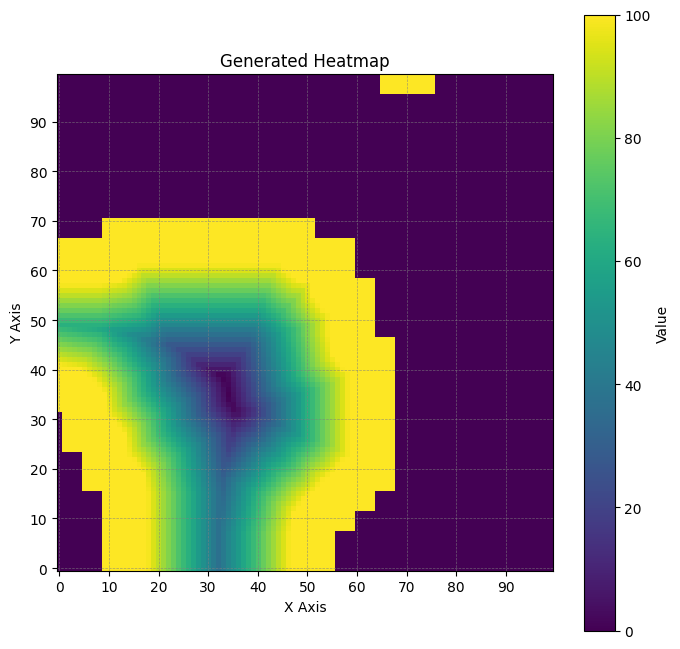

In [39]:
input = createGrid(model_path=model, seed=4)
visualize_grid_with_types(input)
grid = shade_inside_border(input)
# Example usage
normalized_distance_map = calculate_distance_to_border(grid)  # Toggle invert as needed

visualize_grid_with_types(grid)
visualize_heatmap(normalized_distance_map)

other_distance_map = calculate_border_proximity(grid)
visualize_heatmap(other_distance_map)


Might play around with the idea of direct cutoff at the end of this

In [50]:
def label_heatmap_based_on_trees(grid, tree_positions, invert=False, distance_threshold=20):
    """
    Creates a new grid where points with a value of 128 are labeled with 100 or 0 
    based on their proximity to trees. Points within or outside the specified distance 
    threshold are labeled, depending on `invert`.

    Args:
        grid (np.ndarray): The input grid (heatmap values or similar structure).
        tree_positions (list of tuple): List of (y, x) coordinates of tree locations.
        invert (bool): If True, label points outside the distance threshold instead of within it.
        distance_threshold (float): The distance threshold for labeling.

    Returns:
        np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
    """
    # Initialize the new grid with zeros
    labeled_grid = np.zeros_like(grid, dtype=np.float32)
    
    # Identify positions with a value of 128 in the grid
    target_positions = np.argwhere(grid == 128)
    
    # If there are tree positions and target positions, calculate distances
    if len(tree_positions) > 0 and len(target_positions) > 0:
        tree_positions = np.array(tree_positions)
        
        # Calculate distances from target positions to the tree positions
        distances = cdist(target_positions, tree_positions)
        min_distances = np.min(distances, axis=1)
        
        # Determine indices based on the distance threshold
        if invert:
            # Label points outside the distance threshold
            valid_indices = np.where(min_distances > distance_threshold)[0]
        else:
            # Label points within the distance threshold
            valid_indices = np.where(min_distances <= distance_threshold)[0]
        
        # Mark valid target points in the labeled grid
        for index in valid_indices:
            y, x = target_positions[index]
            labeled_grid[y, x] = 100  # Assign the value 100 for valid points

        labeled_grid = np.flipud(labeled_grid)

    return labeled_grid

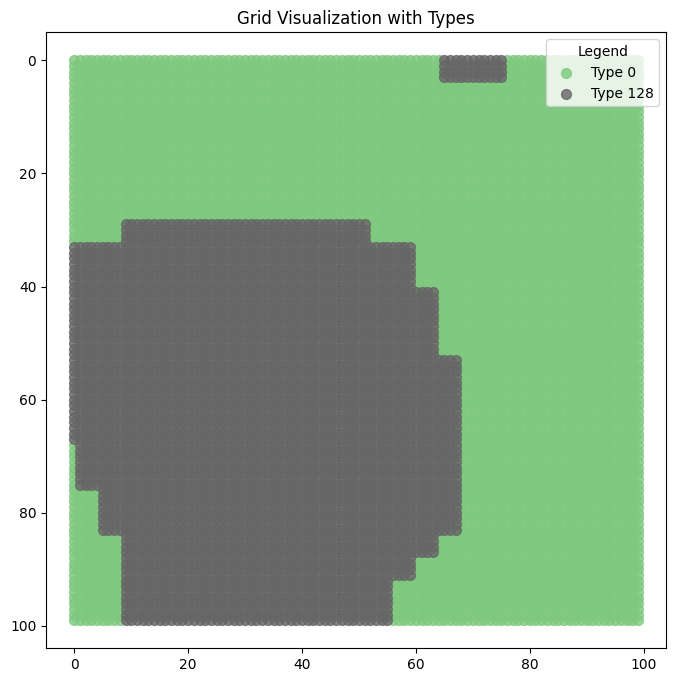

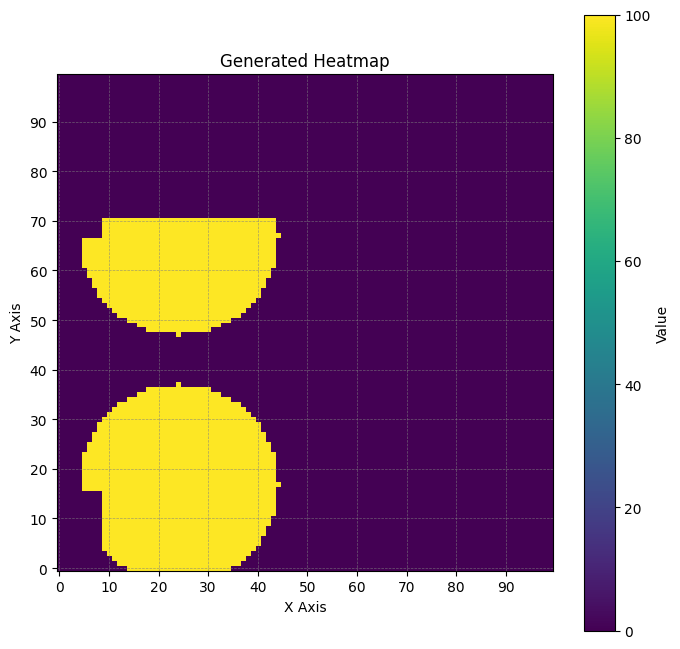

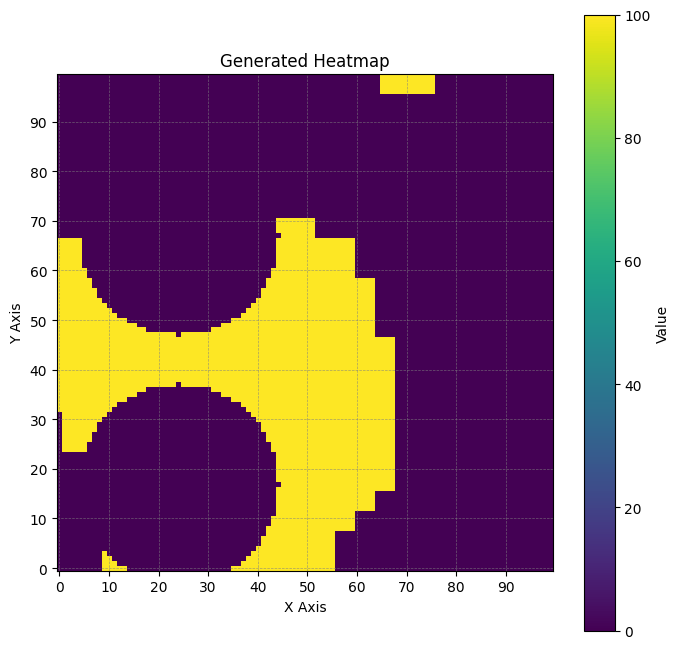

In [54]:
trees, shrubs = extract_tree_shrub_placements(input)
new_grid = label_heatmap_based_on_trees(grid,trees)
visualize_grid_with_types(grid)
visualize_heatmap(new_grid)
new_grid = label_heatmap_based_on_trees(grid,trees,invert=True)
visualize_heatmap(new_grid)



In [ ]:
seeds = [3,4,5,6]

In [113]:
def combine_heatmaps(heatmaps):
    """
    Combine multiple heatmaps into a single heatmap by summing them element-wise.

    Args:
        heatmaps (list of np.ndarray): List of 2D heatmaps to combine.

    Returns:
        np.ndarray: Combined heatmap with the same shape as the input heatmaps.
    """
    if not heatmaps:
        raise ValueError("The list of heatmaps is empty.")
    
    # Ensure all heatmaps have the same shape
    shape = heatmaps[0].shape
    for idx, h in enumerate(heatmaps):
        if h.shape != shape:
            print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
            raise ValueError("All heatmaps must have the same shape.")
    
    # Sum the heatmaps element-wise
    combined = sum(heatmaps)
    
    return combined


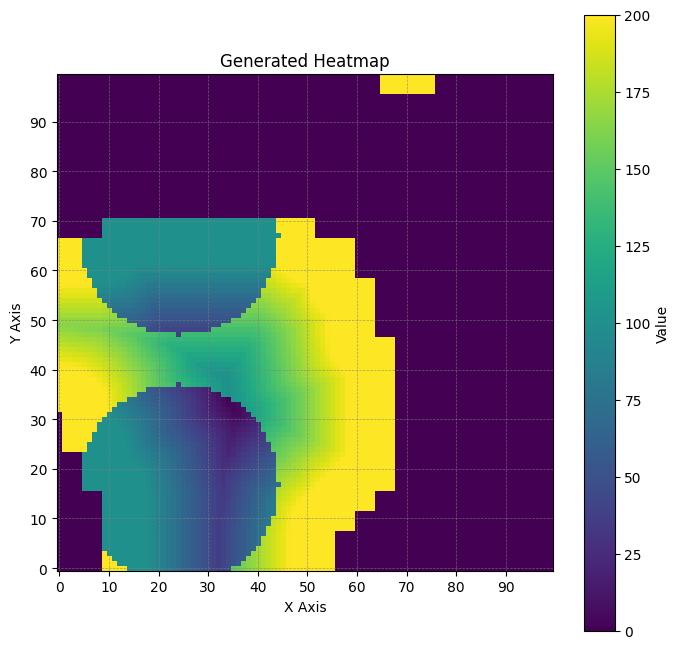

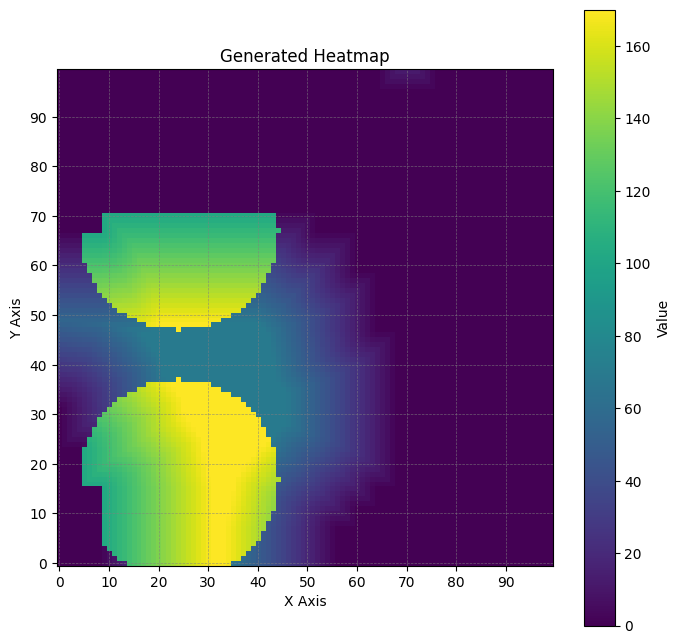

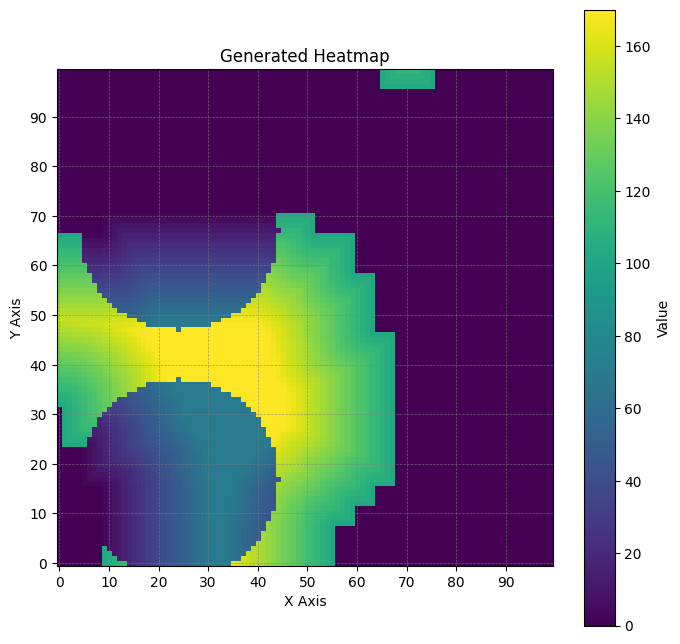

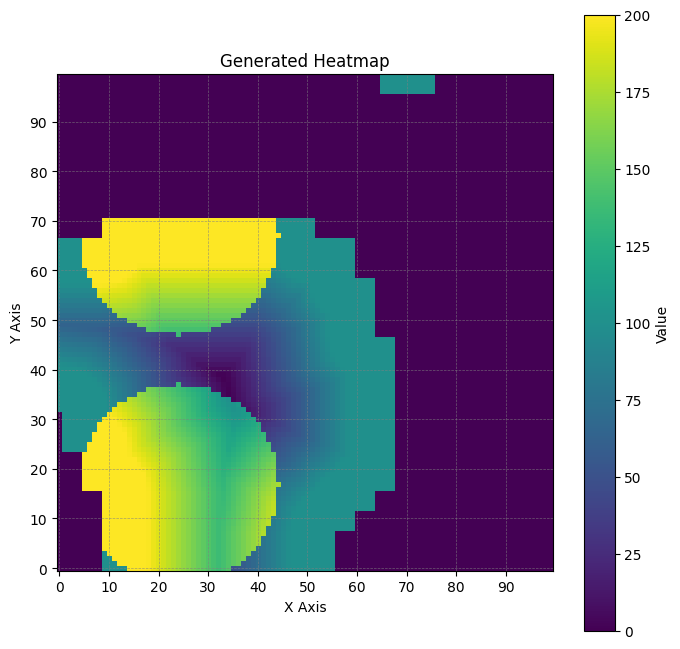

In [62]:
def create_heatmap_for_type(seed_value, grid):
    plantable_grid = shade_inside_border(grid)
    trees, shrubs = extract_tree_shrub_placements(grid)
    # Create the grids to be combined
    shade_grid = None
    # If the thing is a multiple of 2 then it is shade loving
    if seed_value%2 == 0:
        shade_grid = label_heatmap_based_on_trees(plantable_grid,trees)
    else:
        shade_grid = label_heatmap_based_on_trees(plantable_grid, trees, invert=True)
    border_grid = None
    # If the seed_value is a modulus of 3 then it is something that likes the border
    if seed_value%3 ==0:
        border_grid = calculate_border_proximity(plantable_grid)
    else:
        border_grid = calculate_distance_to_border(plantable_grid)
    
    # visualize_heatmap(shade_grid)
    # visualize_heatmap(border_grid)
    influences = [shade_grid,border_grid]
    influence = combine_heatmaps(influences)
    visualize_heatmap(influence)
    return influence


seed_heatmaps = {
    3: create_heatmap_for_type(3, input),
    4: create_heatmap_for_type(4, input),
    5: create_heatmap_for_type(5, input),
    6: create_heatmap_for_type(6, input)
} 

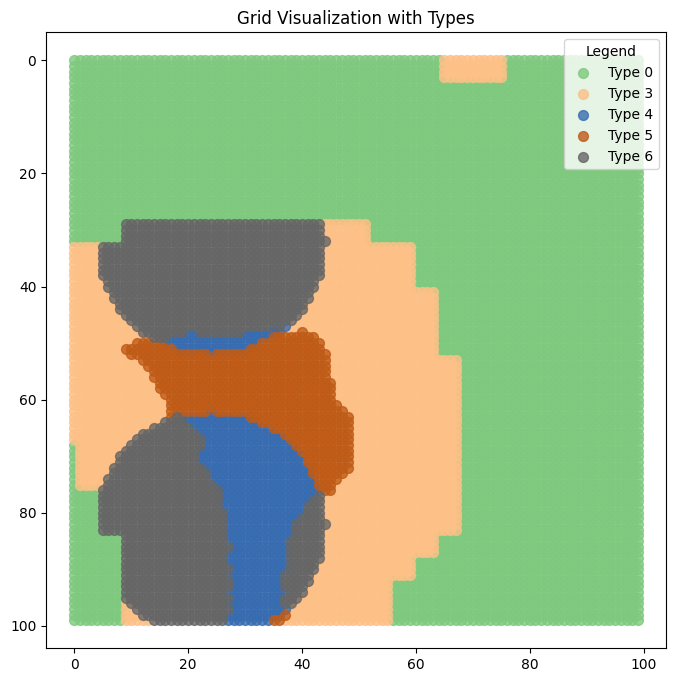

In [160]:
def apply_influence_grids_with_border(influence_grids, grid, threshold=1):
    """
    Apply influence grids to assign plant types based on influences while respecting the border constraints.
    Correct the vertical flip issue by flipping the grid as needed.

    Args:
        influence_grids (dict): A dictionary of influence grids for each plant type.
        grid (np.ndarray): Original grid to determine workable spots.
        threshold (float): The maximum absolute difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with plant types assigned based on influence grids, keeping non-workable spots untouched.
    """
    # Identify workable spots using shade_inside_border
    workable_grid = shade_inside_border(grid)
    
    # Flip grids vertically to address the issue
    flipped_influence_grids = {
        plant_type: np.flipud(influence_grids[plant_type])
        for plant_type in influence_grids
    }
    
    grid_shape = workable_grid.shape

    # Initialize the assigned grid with zeros
    assigned_grid = np.zeros(grid_shape, dtype=int)

    # Iterate through each cell in the grid
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if workable_grid[i, j] == 128:  # Only consider workable spots
                # Gather influences for all plant types at this position
                influences = [
                    (flipped_influence_grids[plant_type][i, j], plant_type)
                    for plant_type in flipped_influence_grids
                ]

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the absolute threshold
                if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= threshold:
                    # Randomly select between the top two types
                    assigned_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    assigned_type = influences[0][1]

                # Assign the type to the corresponding cell
                assigned_grid[i, j] = assigned_type
            else:
                # Retain the original value for non-workable spots (e.g., 0)
                assigned_grid[i, j] = grid[i, j]

    return assigned_grid

newer_grid = apply_influence_grids_with_border(seed_heatmaps, input)
visualize_grid_with_types(newer_grid)

Add a little bit of noise in using the previous functions

In [138]:
def choose_starter_slots(grid, shrub_positions, starter_types, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and updates the grid with new types
    based on the provided list of starter types.

    Args:
        grid (np.ndarray): The current grid representing the environment.
        shrub_positions (list): List of tuples representing the positions of shrubs on the grid.
        starter_types (list): List of integers representing the types to assign.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        tuple: Updated grid with starter slots assigned, and a dictionary of seed locations by type.
    """
    working_grid = copy.deepcopy(grid)
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in starter_types}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    # Use the provided list of starter types in sequence
    types_sequence = [starter_types[i % len(starter_types)] for i in range(number_of_starters)]

    for i, assigned_type in enumerate(types_sequence):
        if not shrub_slots:  # If no more shrub positions are left, break the loop
            break
        selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
        working_grid[selected_position[0], selected_position[1]] = assigned_type
        seed_locations[assigned_type].append(selected_position)

    return working_grid, seed_locations

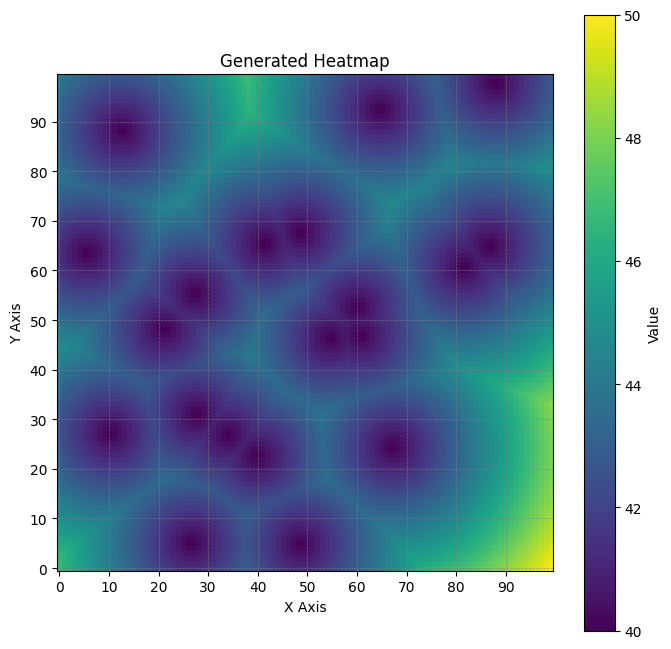

In [150]:
def generate_worley_heatmap(grid_size=(100, 100), distribution_seed=None, value_range=(40, 50), feature_points=20, invert=False):
    """
    Generate a random heatmap using Worley noise.

    Args:
        grid_size (tuple): The size of the heatmap (width, height).
        distribution_seed (int or None): Seed for reproducibility.
        value_range (tuple): The range of values for the heatmap (min, max).
        feature_points (int): Number of feature points in the grid.
        invert (bool): Whether to invert the values so that centers of the points are high-value areas.

    Returns:
        np.ndarray: A 2D array representing Worley noise.
    """
    width, height = grid_size

    # Set random seed for reproducibility
    if distribution_seed is not None:
        random.seed(distribution_seed)

    # Generate random feature points
    feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

    def closest_distance(x, y):
        # Compute the closest distance to a feature point
        return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

    # Compute Worley noise for the grid
    noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

    # Normalize the noise to 0-1
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

    # Invert the noise if required
    if invert:
        noise = 1 - noise

    # Scale the noise to the desired value range
    min_val, max_val = value_range
    noise = noise * (max_val - min_val) + min_val

    return noise

heatmap = generate_worley_heatmap()
visualize_heatmap(heatmap)

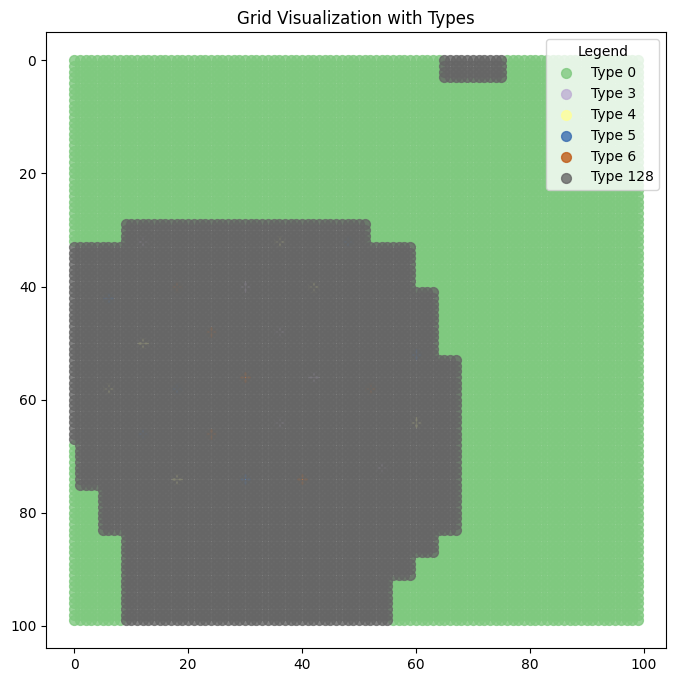

{3: [(32, 12), (40, 30), (48, 36), (56, 42), (64, 36), (72, 54)], 4: [(32, 36), (40, 42), (50, 12), (58, 6), (64, 60), (74, 18)], 5: [(32, 48), (42, 6), (52, 60), (58, 18), (66, 12), (74, 30)], 6: [(40, 18), (48, 24), (56, 30), (58, 52), (66, 24), (74, 40)]}


In [ ]:
trees, shrubs = extract_tree_shrub_placements(input)
working_grid, seed_locations = choose_starter_slots(grid, shrubs, number_of_types=4)

visualize_grid_with_types(working_grid)
print(seed_locations)

In [107]:
def radiate_influence(grid, noise_map, seed_locations, decay_rate=0.1):
    """
    Radiates influence from each seed location based on its strength on the noise map, taking the maximum influence.

    Args:
        grid (np.ndarray): The input grid where influence will be applied.
        noise_map (np.ndarray): A grid representing the noise values.
        seed_locations (list of tuple): List of (y, x) seed coordinates.
        decay_rate (float): The rate at which influence decreases with distance.

    Returns:
        np.ndarray: A grid with the maximum influence from all seeds.
    """
    # Initialize the influence grid with zeros
    influence_grid = np.zeros_like(grid, dtype=np.float32)

    # Get grid dimensions
    height, width = grid.shape

    # Iterate over each seed
    for y, x in seed_locations:
        # Get the seed's strength from the noise map
        if 0 <= y < height and 0 <= x < width:
            seed_strength = noise_map[y, x]

            # Iterate over the grid to calculate influence
            for i in range(height):
                for j in range(width):
                    # Calculate the distance from the seed
                    distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                    # Calculate the influence based on the distance
                    influence = seed_strength * np.exp(-decay_rate * distance)

                    # Assign the maximum influence to the grid
                    influence_grid[i, j] = max(influence_grid[i, j], influence)

    influence_grid = np.flipud(influence_grid)

    return influence_grid


noise_grids =  {
    3: radiate_influence(input, heatmap, seed_locations[3]),
    4: radiate_influence(input, heatmap, seed_locations[4]),
    5: radiate_influence(input, heatmap, seed_locations[5]),
    6: radiate_influence(input, heatmap, seed_locations[6]),              
}

In [143]:
def create_heatmap_for_type(seed_value, grid, noise_grid):
    plantable_grid = shade_inside_border(grid)
    trees, shrubs = extract_tree_shrub_placements(grid)
    # Create the grids to be combined
    shade_grid = None
    # If the thing is a multiple of 2 then it is shade loving
    if seed_value%2 == 0:
        shade_grid = label_heatmap_based_on_trees(plantable_grid,trees)
    else:
        shade_grid = label_heatmap_based_on_trees(plantable_grid, trees, invert=True)
    border_grid = None
    # If the seed_value is a modulus of 3 then it is something that likes the border
    if seed_value%3 ==0:
        border_grid = calculate_border_proximity(plantable_grid)
    else:
        border_grid = calculate_distance_to_border(plantable_grid)
    
    # visualize_heatmap(shade_grid)
    # visualize_heatmap(border_grid)
    influences = [shade_grid,border_grid, noise_grid]
    influence = combine_heatmaps(influences)
    # visualize_heatmap(influence)
    return influence


seed_heatmaps = {
    3: create_heatmap_for_type(3, input, noise_grids[3]),
    4: create_heatmap_for_type(4, input, noise_grids[4]),
    5: create_heatmap_for_type(5, input, noise_grids[5]),
    6: create_heatmap_for_type(6, input, noise_grids[6])
} 

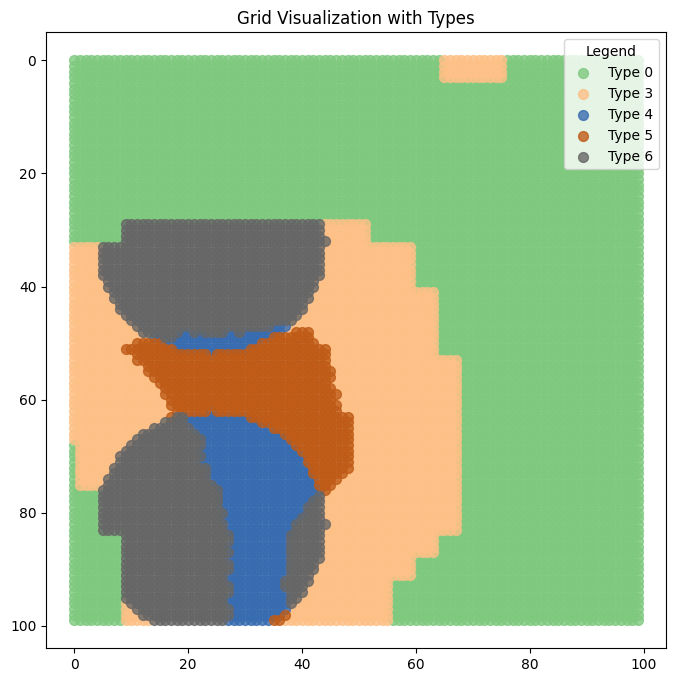

In [109]:
newer_grid = apply_influence_grids_with_border(seed_heatmaps, input)
visualize_grid_with_types(newer_grid)

In [141]:
def combined_noisemap(grid, noise_map, seed_dict):
    seed = {}
    for i in seed_dict:
        seed[i] = radiate_influence(grid, noise_map, seed_dict[i])
    return seed

In [121]:
def create_heatmaps(seed_list, grid, noise_grids):
    seed_heatmaps = {}
    for i in seed_list:
        seed_heatmaps[i] = create_heatmap_for_type(i,grid, noise_grids[i])
    return seed_heatmaps

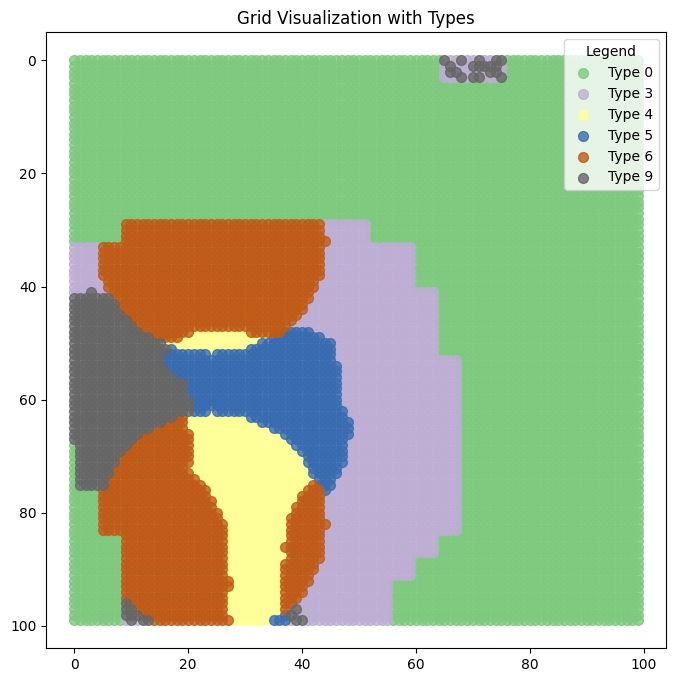

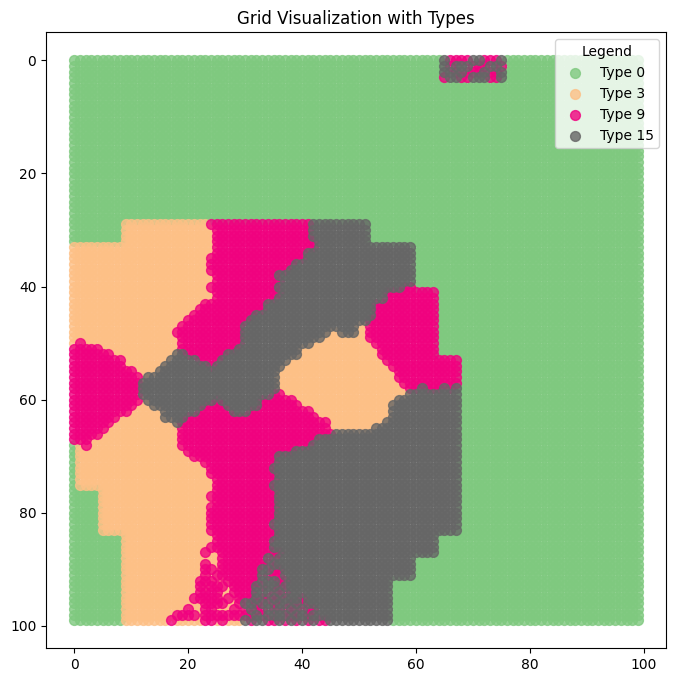

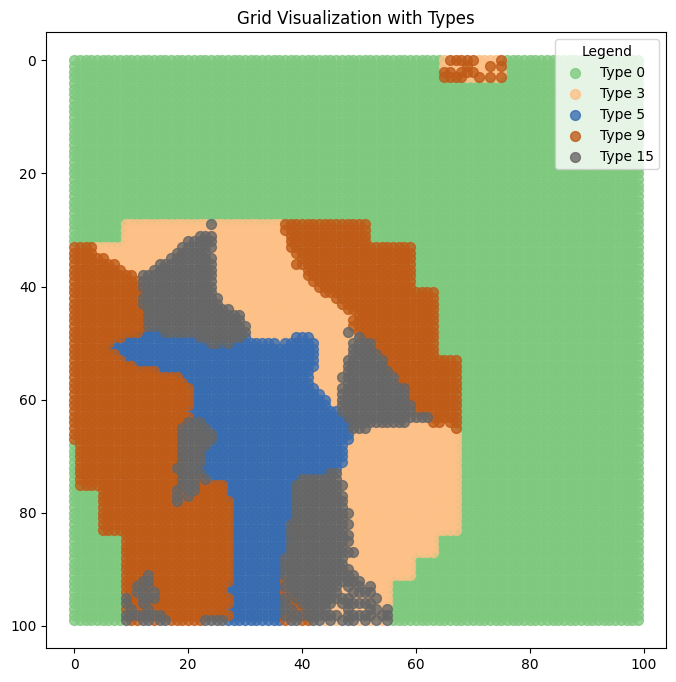

In [161]:
def combined(input_grid, seed_list):
    trees, shrubs = extract_tree_shrub_placements(input)
    working_grid, seed_locations = choose_starter_slots(input,shrubs, (seed_list))
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_list,input_grid,noise_grids)
    output_grid = apply_influence_grids_with_border(heatmaps, input)

    visualize_grid_with_types(output_grid)
    return output_grid
    

output_grid = combined(input, [3,4,5,6,9])
output_grid = combined(input, [3,9,15])
output_grid = combined(input, [3,5,9,15])